# Image Denoising
    
*   Mykola Liashuha
*   Jose Gonzalez Lopez

# Introduction
This is the intro

# Imports

In [1]:
import scipy #Library for signal analysis
import matplotlib.pyplot as plt #Plot
import numpy as np #Operations
import cv2 #Read images and do operations
import IPython.display as ipd
import numpy.random #For generating noise

from numpy import linalg

from scipy.io import wavfile #Read wavfiles
from scipy.signal import welch,stft,istft #Get power density estimated, short fourier transform

#Numerical tools imports
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.perform_wavelet_transf import *
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Auxiliar Functions

In [2]:
'''
Return the masked image with a mask omega 
'''
def Phi(f,omega):
    return f*(1-omega)

In [3]:
'''
Return the soft thresholding operator
'''
def SoftThresh(x, T): 
    return x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))

In [4]:
'''
From wavelet domain to real domain
'''
def Psi(a,Jmin):
    return perform_wavelet_transf(a, Jmin, -1, ti=0)

In [5]:
'''
From real domain to wavelet domain
'''
def PsiS(f,Jmin): 
    return perform_wavelet_transf(f, Jmin, +1, ti=0)

In [6]:
'''
Apply softThresholding while round trip to wavelet domain
'''
def SoftThreshPsi(f, T, Jmin):
    return Psi(SoftThresh(PsiS(f,Jmin), T),Jmin)

In [7]:
'''
Projection operation for orthogonal
'''
def ProjC(f, omega,y): 
    return omega*f + (1-omega)*y

In [8]:
'''
Projection operation for invariant
'''
def Xi(a,Jmin): 
    return perform_wavelet_transf(a, Jmin, -1, ti=1)

In [9]:
'''
From real domain to wavelet domain
'''
def PsiS_a(f,Jmin): 
    return perform_wavelet_transf(f, Jmin, + 1, ti=1)

In [10]:
'''
From wavelet domain to real domain
'''
def Psi_a(a,U,Jmin): 
    return Xi(a/U,Jmin)

# Loading Data
Below we load the image, normalize it to set values between [0,1]

In [11]:
img = cv2.imread('barbara.jpg') #Image
gray = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) #Covert to one channel, black and white
gray = gray / 255. #Normalize

height,width = gray.shape


# Direct problem generator
We are going to create the image by first creating the binary mask, apply it to the image and then sum some white noise.

In [12]:
observed_images=[]
omegas=[]
#stds = [0.42,0.25, 0.16, 0.08, 0.04] #White noises
#probabilities=np.arange(0,1,0.1)
stds=[0.04]
probabilities=[0.3]
for p in probabilities:
    omega=np.random.binomial(1,p,(height,width))
    omegas.append(omega)
    masked=Phi(gray,omega)
    for std in stds:
        noise = np.random.normal(0, 1, size=gray.shape)
        obs_img = masked + std*noise 
    observed_images.append(obs_img)


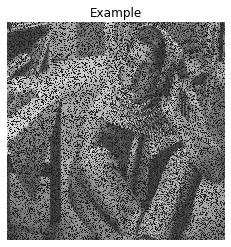

In [13]:
imageplot(observed_images[0], 'Example')

# Inpainting using Orthogonal Wavelet Sparsity

## Soft Thresholding

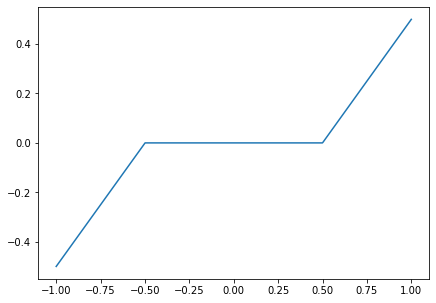

In [14]:
x = np.linspace(-1, 1, 1000)

plt.figure(figsize=(7,5))
plt.plot(x, SoftThresh(x,.5))
plt.show()

In [15]:
#lambdas=np.arange(0,1,0.1)
lambdas=[0.3]

In [16]:
Jmax = np.log2(height)-1
Jmin = Jmax-3

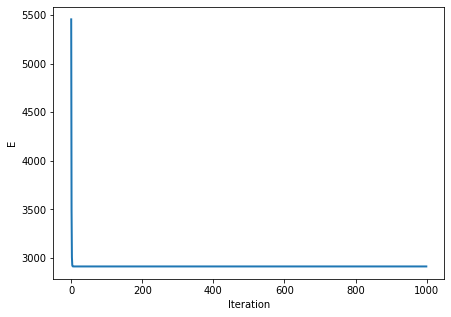

In [17]:
reconstructed_images=[]
for i in range(len(observed_images)):
    y=observed_images[i]
    fSpars=observed_images[i]
    omega=omegas[i]
    for lambd in lambdas:
        energy = []
        niter = 1000
        for j in range(niter):
            fSpars = SoftThreshPsi(ProjC(fSpars, omega, y), lambd,Jmin)
            # record the energy
            fW = PsiS(fSpars,Jmin)
            energy = energy + [1/2*linalg.norm(y-Phi(fSpars, omega),"fro")**2 + lambd*np.sum(abs(fW))]
    
        reconstructed_images.append(fSpars)
        plt.figure(figsize=(7,5))
        plt.plot(energy, linewidth=2)
        plt.xlabel("Iteration")
        plt.ylabel("E")
        plt.show()

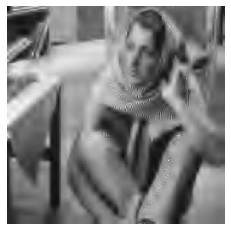

In [18]:
plt.figure(figsize=(4,4))
imageplot(clamp(fSpars))

# Inpainting using Translation Invariant Wavelet Sparsity

## Soft Thresholding

In [19]:
J = Jmax-Jmin + 1
u = np.hstack(([4**(-J)], 4**(-np.floor(np.arange(J + 2./3,1,-1./3)))))
U = np.transpose(np.tile(u, (height,width,1)),(2,0,1))

In [20]:
tau = 1.9*np.min(u)

In [21]:
lambdas=[0.3]

In [26]:
reconstructed_images=[]
for i in range(len(observed_images)):
    #print(i)
    y=observed_images[i]
    fSpars=observed_images[i]
    omega=omegas[i]
    for lambd in lambdas:
        a = U*PsiS_a(fSpars,Jmin)
        E = []
        niter=100
        for j in range(niter):
            #print(j)
            fTI = Psi_a(a,U,Jmin)
            d = y-Phi(fTI, omega)
            E = E + [1/2*linalg.norm(d , 'fro')**2 + lambd*np.sum(abs(a))]
            # step 
            a = SoftThresh(a + tau*PsiS_a(Phi(d, omega),Jmin), lambd*tau)
        fTI = Psi_a(a,U,Jmin)
        reconstructed_images.append(fTI)

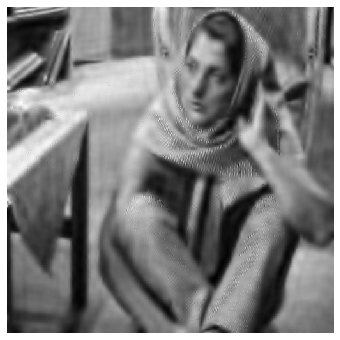

In [27]:
plt.figure(figsize=(6,6))
imageplot(clamp(fTI))